## 酒店预定分类和预测
数据集：Hotel booking demand

该数据集包含城市酒店和度假酒店的预订信息，包括预订时间、停留时间，成人/儿童/婴儿人数以及可用停车位数量等信息。

数据量：32列共12W数据。

基于这个数据集，可进行以下问题的探索：

1. 基本情况：城市酒店和假日酒店预订需求和入住率比较；  
2. 用户行为：提前预订时间、入住时长、预订间隔、餐食预订情况；  
3. 一年中最佳预订酒店时间；  
4. 利用Logistic和随机森林预测酒店预订。

In [1]:
import pandas as pd

data = pd.read_csv('hotel_bookings.csv')

## 1.1 城市酒店和假日酒店的预定需求和入住比例

绘制饼图，分析城市酒店和假日酒店的预定需求和入住比例  
* 从预定需求上看，城市酒店预定需求(66%)大概是假日酒店(33%)的两倍  
* 从实际入住人数上看，城市酒店(61%)大概是假日酒店(38%)的1.5倍 

Text(0.5, 1.0, 'Check in')

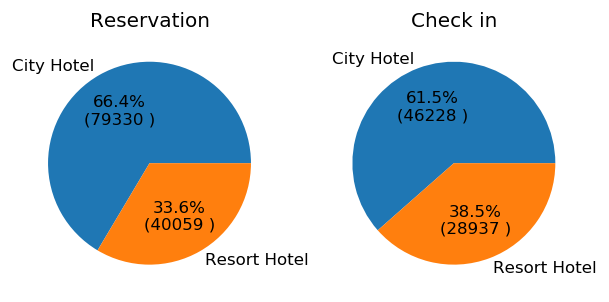

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_label(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

fig, axes = plt.subplots(1, 2, dpi=120)
# 有多少人分别预定了城市酒店和假日酒店
reservations = data['hotel'].value_counts()
axes[0].pie(reservations.values, autopct=lambda x: my_label(x,reservations.values), labels=reservations.index)
axes[0].set_title('Reservation')

# 有多少人最终入住了城市酒店和假日酒店
checkin = data.loc[data.is_canceled==0, 'hotel'].value_counts()
axes[1].pie(checkin.values, autopct=lambda x: my_label(x, checkin.values), labels=checkin.index)
axes[1].set_title('Check in')

## 1.2 城市酒店和假日酒店的入住率

绘制饼图，分析城市酒店和假日酒店的入住率  
* 从入住率看，城市酒店的入住率(58%)比假日酒店的入住率(72%)低  
* 从入住人数看，城市酒店的入住人数(46227)是假日酒店的入住人数(28938)的1.6倍

In [3]:
cancel_rate = data.groupby(['hotel']).apply(lambda x: x['is_canceled'].value_counts())

cancel_rate

is_canceled,0,1
hotel,,
City Hotel,46228,33102
Resort Hotel,28938,11122


Text(0.5, 1.0, 'Reservations of Resort Hotel')

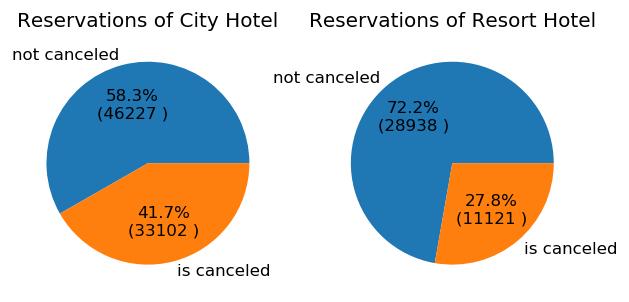

In [4]:
def my_label(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

fig, axes = plt.subplots(1, 2, dpi=120)

axes[0].pie(cancel_rate.loc['City Hotel', :], labels=['not canceled', 'is canceled'],autopct=lambda x: my_label(x,cancel_rate.loc['City Hotel', :].values))
axes[0].set_title('Reservations of City Hotel')
axes[1].pie(cancel_rate.loc['Resort Hotel', :], labels=['not canceled', 'is canceled'],autopct=lambda x: my_label(x,cancel_rate.loc['Resort Hotel', :].values))
axes[1].set_title('Reservations of Resort Hotel')

## 2.1 各年份预定时间分布
绘制折线图，分析各年份预定时间分布  
* 15年前半年是淡季，从七月开始酒店预定需求增加，九月十月是预定高峰  
* 16年全年均有较大的预定需求，年初和年末预定需求较大
* 17年前半年是旺季，后半年是淡季节，春夏是预定高峰

In [5]:
from datetime import datetime, timedelta

date = "2018-6-22"
date = datetime.strptime(date, "%Y-%m-%d")

date + timedelta(10)

datetime.datetime(2018, 7, 2, 0, 0)

In [7]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_map = dict(zip(months, range(1, len(months)+1)))
arrival_month = data.arrival_date_month.map(month_map)

book_arrival = pd.DataFrame({'arrival_year': data.arrival_date_year, 'arrival_month': arrival_month, 'arrival_day': data.arrival_date_day_of_month})
book_arrival['arrival_date'] = book_arrival.apply(lambda x: datetime.strptime('{}-{}-{}'.format(x.arrival_year, x.arrival_month, x.arrival_day), "%Y-%m-%d"), axis=1)
book_arrival['lead_time'] = data.lead_time
book_arrival['booking_date'] = book_arrival['arrival_date'] - book_arrival.lead_time.map(lambda x: timedelta(x))


In [8]:
booking_date = book_arrival.booking_date.map(lambda x: x.strftime("%Y-%m-%d")).str.split('-', expand=True)
booking_date.columns = ['booking_year', 'booking_month', 'booking_day']
booking_date.booking_month = booking_date.booking_month.astype(int)
booking_date.booking_month = booking_date.booking_month.map(dict(zip(range(1, 13), months)))

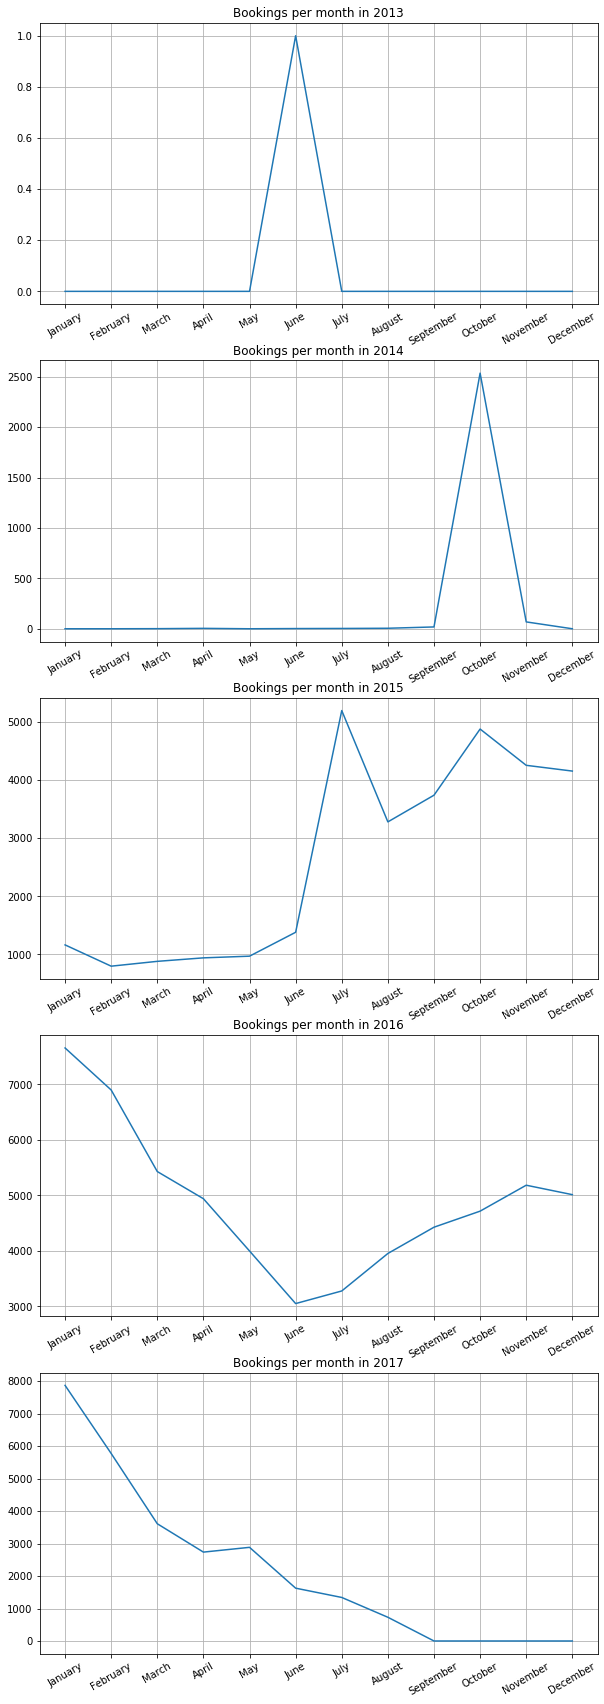

In [9]:
groups = booking_date.groupby(['booking_year'])

fig, axes = plt.subplots(5, 1, figsize=(10, 30))
for i, (name, group) in enumerate(groups):
    month_reserve = group['booking_month'].value_counts().to_dict()
    reserves = [month_reserve[month] if month in month_reserve else 0 for month in months]
    axes[i].plot(months, reserves)
    
    axes[i].set_xticks(months)
    tik = axes[i].get_xticklabels()
    for t in tik:
        t.set_rotation(30)
    axes[i].grid()
    axes[i].set_title('Bookings per month in {}'.format(name))

## 2.2 各年份入住时间分布

绘制折线图，分析各年份入住时间分布  
* 15年前半年是淡季，从七月开始酒店入住量增加，九月十月是入住高峰  
* 16年全年均有较大的入住量，二月以后月入住量超过4000
* 17年前半年是旺季，后半年是淡季节，春夏是入住高峰

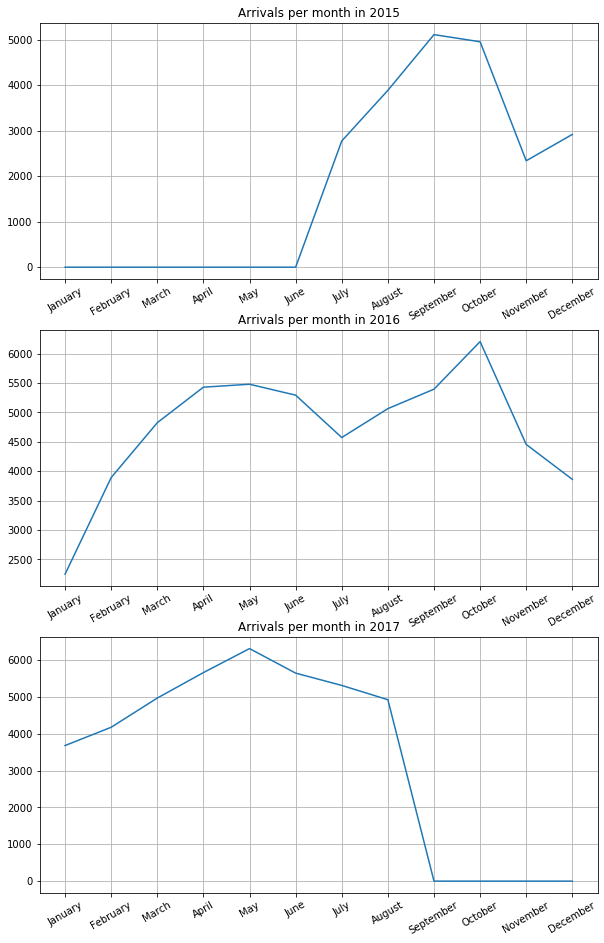

In [10]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
groups = data.groupby(['arrival_date_year'])

fig, axes = plt.subplots(3, 1, figsize=(10, 16))
for i, (name, group) in enumerate(groups):
    month_reserve = group['arrival_date_month'].value_counts().to_dict()
    reserves = [month_reserve[month] if month in month_reserve else 0 for month in months]
    axes[i].plot(months, reserves)
    
    axes[i].set_xticks(months)
    tik = axes[i].get_xticklabels()
    for t in tik:
        t.set_rotation(30)
    axes[i].grid()
    axes[i].set_title('Arrivals per month in {}'.format(name))

## 2.3 入住天数

绘制饼图和柱状图分析用户入住天数  
* 大部分用户入住天数在7天以内
* 超过50%的用户入住天数不超过3天

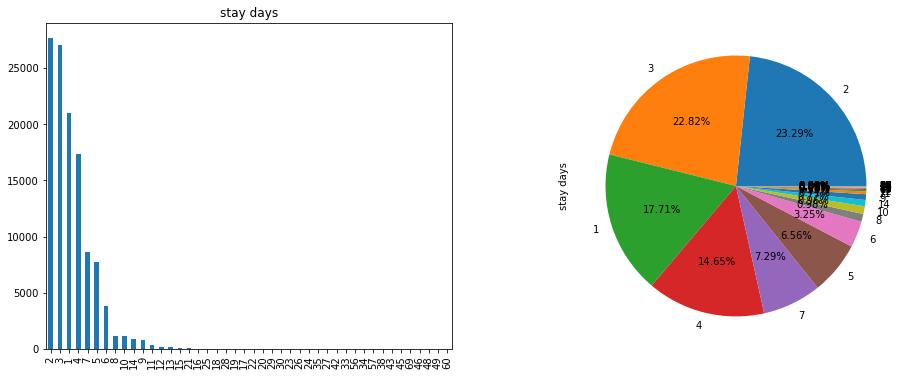

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 柱状图
stays = data.stays_in_week_nights + data.stays_in_weekend_nights
stays = stays[stays > 0]
stays.value_counts().plot.bar(ax=axes[0])
axes[0].set_title('stay days')

# 饼图
stay_rate = stays.value_counts()/stays.shape[0]
stay_rate.plot.pie(label='stay days', autopct='%.2f%%', ax=axes[1])

## 3. 最佳预定时间

* 如果考虑价格，最佳预定时间是二月  
* 考虑淡季旺季，一月和二月人数均较少

综上，二月便宜人又少

In [92]:
data['price_pp'] = data["adults"] + data["children"]
data['price_pp'] = data.loc[data.price_pp > 0, "adr"] / data.loc[data.price_pp > 0, "price_pp"] 

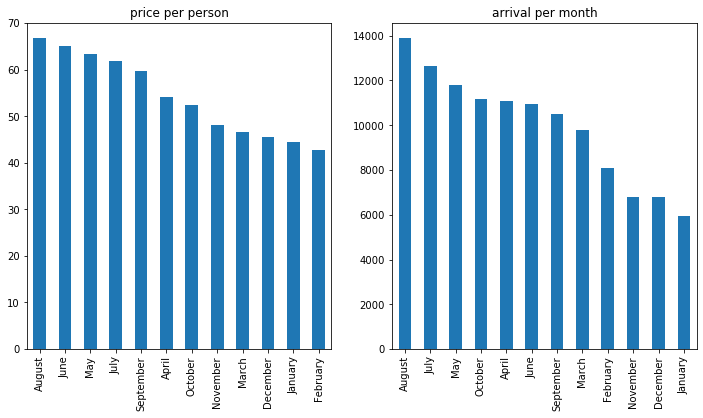

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 人均价格
price_pp = data[data.price_pp > 0].groupby(['arrival_date_month'])['price_pp'].mean()
price_pp.index.name = ''
price_pp = price_pp.sort_values(ascending=False)
price_pp.plot.bar(title='price per person', ax=axes[0])

# 入住人数
data['arrival_date_month'].value_counts().plot.bar(ax=axes[1], title='arrival per month')

## 4.1 利用Logistic预测酒店预订

In [132]:
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

df = data
num_var = ["lead_time","arrival_date_week_number","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest", "previous_cancellations","previous_bookings_not_canceled","agent","company","required_car_parking_spaces", "total_of_special_requests", "adr"]
cat_var = ["hotel","arrival_date_month","meal","market_segment","distribution_channel","reserved_room_type","deposit_type","customer_type"]


features = num_var + cat_var
X= df.drop(["is_canceled"], axis=1)[features]
y = df["is_canceled"]

num_transformer = SimpleImputer(strategy="constant")

cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_var),("cat", cat_transformer, cat_var)])

# 逻辑斯蒂回归
rf = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf)])

cv_results = cross_val_score(model_pipe, X, y, cv=kf, scoring="accuracy",n_jobs=-1)

min_score = round(min(cv_results), 10)
max_score = round(max(cv_results), 10)
mean_score = round(np.mean(cv_results), 10)
std_dev = round(np.std(cv_results), 10)
print(f"LogisticRegression model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

LogisticRegression model cross validation accuarcy score: 0.7953764972 +/- 0.0028250546 (std) min: 0.79135606, max: 0.8000670073


## 4.2 利用随机森林预测酒店预订

In [131]:
# 随机森林
rf = RandomForestClassifier(n_jobs=-1,random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf)])

cv_results = cross_val_score(model_pipe, X, y, cv=kf, scoring="accuracy",n_jobs=-1)

min_score = round(min(cv_results), 10)
max_score = round(max(cv_results), 10)
mean_score = round(np.mean(cv_results), 10)
std_dev = round(np.std(cv_results), 10)
print(f"Random Forest model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Random Forest model cross validation accuarcy score: 0.8695284362 +/- 0.0018725547 (std) min: 0.8657341486, max: 0.8723511182
